In [ ]:
# Run this cell first to install all necessary packages.
!pip install earthengine-api > /dev/null
!pip install geemap > /dev/null
!pip install stable-baselines3 > /dev/null
#!pip install gymnasium > /dev/null
!pip install --upgrade gymnasium > /dev/null

In [ ]:
# Import all the tools we need
import ee
import geemap
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
import io

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
class RealWorldClimateEnv(gym.Env):
    """
    A realistic simulation of a region facing climate risks, using real data and a comprehensive action space.
    The AI must manage a budget and choose between short-term fixes and long-term resilience investments.
    """
    def __init__(self, historical_data):
        super(RealWorldClimateEnv, self).__init__()
        self.historical_data = historical_data

        # Initialize attributes that will be used in step(), even if their final value is set in reset()
        self.budget = None # Initialize budget
        self.current_year = None # Initialize current year
        self.dam_years_left = None # Initialize dam years left
        self.dam_completed = False # Initialize dam completed flag
        self.health_infrastructure = None # Initialize health infrastructure
        self.education_level = None # Initialize education level
        self.agroforestry_level = None # Initialize agroforestry level
        self.initial_poverty = None # Initialize initial poverty for reward calculation
        self.population = None # Initialize population


        # Actions: The AI can choose one of 9 policies each year.
        # 0: Do Nothing
        # 1: Build Irrigation Systems
        # 2: Subsidize Drought-Resistant Crops
        # 3: Develop Early Warning Systems
        # 4: Fund Microfinance Loans
        # 5: Invest in Community Health Programs
        # 6: Invest in Education
        # 7: Agroforestry / Mangrove Restoration
        # 8: Build a Water Reservoir (Dam)
        self.action_space = spaces.Discrete(9)

        # State (s_t): A rich description of the region's status.
        # [current_year, budget, poverty_rate, population, rain_anomaly, health_infrastructure, education_level, agroforestry_level, dam_years_left]
        # Updated observation space to include population and a higher upper bound
        self.observation_space = spaces.Box(low=0, high=2000000, shape=(9,), dtype=np.float32) # Increased upper bound for population growth

        # self.reset() # Don't call reset in __init__ when using DummyVecEnv with a lambda that creates new instances

    def step(self, action):
        # Advance the year
        self.current_year += 1
        terminated = False # Initialize terminated to False
        truncated = False # Initialize truncated to False


        # 1. GET REAL OR SIMULATED CLIMATE DATA FOR THIS YEAR
        if self.current_year in self.historical_data:
            data = self.historical_data[self.current_year]
            # Add checks for missing keys and provide default values
            rain = data.get('rainfall', np.mean([v['rainfall'] for v in self.historical_data.values() if 'rainfall' in v]) if any('rainfall' in v for v in self.historical_data.values()) else 0)
        else:
            # For future years: base rain on past average plus a random shock
            past_avg_rain = np.mean([v['rainfall'] for k, v in self.historical_data.items() if k < self.current_year and 'rainfall' in v]) if any('rainfall' in v for v in self.historical_data.values()) else 0
            rain = max(0, past_avg_rain + np.random.normal(0, 100))

        # Calculate a "rainfall anomaly" (how different from normal)
        past_years_data = [v['rainfall'] for k, v in self.historical_data.items() if k < self.current_year and 'rainfall' in v]
        past_avg_rain = np.mean(past_years_data) if past_years_data else 0
        rain_anomaly = (rain - past_avg_rain) / past_avg_rain if past_avg_rain != 0 else 0

        # 2. APPLY THE AI'S CHOSEN POLICY (ACTION)
        cost = 0
        climate_impact = rain_anomaly * -10  # Negative anomaly (drought) has positive (bad) impact

        # --- Define Costs for Each Action (Adjusted Costs for more variety) ---
        # Costs are NOT scaled by population
        if action == 0:
            cost = 0  # Do Nothing
        elif action == 1:
            cost = 4  # Irrigation (slightly reduced cost)
        elif action == 2:
            cost = 6  # Drought Crops (slightly reduced cost)
        elif action == 3:
            cost = 5  # Early Warning (reduced cost)
        elif action == 4:
            cost = 4  # Microfinance (reduced cost)
        elif action == 5:
            cost = 7  # Health Programs (slightly increased cost)
        elif action == 6:
            cost = 4  # Education (reduced cost)
        elif action == 7:
            cost = 8  # Agroforestry (reduced cost)
        elif action == 8:  # Dam
            if self.dam_years_left is not None and self.dam_years_left > 0: # Added check for None
                cost = 7  # Continued annual cost (increased)
            else:
                cost = 10  # First year payment (same)
                self.dam_years_left = 3  # A 3-year project

        # Subtract the cost from the budget, preventing negative budget
        self.budget -= cost
        if self.budget < 0:
            self.budget = 0
            cost = 0  # If we can't pay, the action fails and has no effect

        # --- Calculate Direct Effects of Climate and Mitigating Actions (Adjusted Impacts) ---
        # Net impact starts as the raw climate impact
        net_impact = climate_impact
        poverty_reduction_from_action = 0 # Initialize direct poverty reduction from actions

        # Actions with direct climate mitigation + potential poverty reduction
        if action == 1 and cost > 0:
            net_impact -= 0.8 * cost # Irrigation effectiveness
            poverty_reduction_from_action += 0.2 # Small immediate poverty reduction from increased yields
        elif action == 2 and cost > 0:
            net_impact -= 0.6 * cost  # Drought-resistant crops effectiveness
            poverty_reduction_from_action += 0.4 # Small immediate poverty reduction from crop survival
        elif action == 3 and cost > 0:
            net_impact -= 0.4 * cost # Early warnings effectiveness (mostly avoids bigger losses)
            poverty_reduction_from_action += 0.6 # Very small immediate poverty reduction from avoided losses

        # Actions with primary impact on state variables or more direct poverty links
        if action == 4 and cost > 0:
            poverty_reduction_from_action += 0.5 # Increased immediate poverty reduction from Microfinance
        elif action == 5 and cost > 0:
            self.health_infrastructure = min(10.0, self.health_infrastructure + 1.5) # Increased health gain
            poverty_reduction_from_action += 0.3 # Small indirect poverty reduction from better health
        elif action == 6 and cost > 0:
            self.education_level = min(10.0, self.education_level + 2.5) # Increased education gain
            poverty_reduction_from_action += 0.6 # Very small indirect poverty reduction from education
        elif action == 7 and cost > 0:
            self.agroforestry_level = min(10.0, self.agroforestry_level + 1.5) # Increased agroforestry gain
            poverty_reduction_from_action += 0.4 # Small indirect poverty reduction from diversified income

        # Action 8: Dam - handle multi-year project
        if action == 8 and self.dam_years_left is not None and self.dam_years_left > 0: # Added check for None
            self.dam_years_left -= 1
            if self.dam_years_left <= 0:
                self.dam_completed = True
                # print("Dam Project Completed!") # Useful for debugging
        elif action == 8 and self.dam_years_left is None: # Handle the case where Dam is chosen for the first time
             cost = 10
             self.dam_years_left = 3 # A 3-year project
             self.budget -= cost # Subtract cost for the first year
             if self.budget < 0:
                 self.budget = 0
                 cost = 0 # If we can't pay, action fails
                 self.dam_years_left = None # Reset dam project if it fails in the first year


        # --- APPLY ANNUAL, PASSIVE EFFECTS FROM PAST INVESTMENTS ---
        # Education makes the population more effective (all policies work a bit better, and better income)
        education_boost = 1 + (self.education_level / 15)  # Max education gives a 25% boost
        net_impact *= education_boost
        poverty_reduction_from_action *= education_boost # Education also boosts policy effectiveness

        # Agroforestry generally buffers all climate impacts and provides diversified income
        agroforestry_buffer = 1 - (self.agroforestry_level / 15)  # Max agroforestry reduces climate impact
        net_impact *= max(0, agroforestry_buffer) # Ensure net_impact doesn't become negative due to buffer
        poverty_reduction_from_action += self.agroforestry_level * 0.1 # Agroforestry provides ongoing income/buffer

        # A completed dam NULLIFIES drought impacts and provides irrigation benefits
        if hasattr(self, 'dam_completed') and self.dam_completed and rain_anomaly < 0:
             net_impact = 0  # The dam saves the day in a drought
             poverty_reduction_from_action += 0.1 # Dam also directly helps poverty via irrigation benefits
             self.budget -= 1  # Small maintenance cost


        # Health Infrastructure reduces the negative impact of high poverty/crises
        health_buffer = self.health_infrastructure / 20 # Max health gives a 50% buffer against poverty increase
        net_impact *= (1 - health_buffer) # Reduce the negative impact based on health infra


        # 3. UPDATE THE REGION'S STATUS BASED ON NET IMPACT AND DIRECT ACTION EFFECTS
        # Poverty changes based on the net impact of climate, passive effects, AND direct action effects
        # Poverty change is NOT scaled by population
        poverty_change = (net_impact * 0.1) - poverty_reduction_from_action
        self.poverty_rate += poverty_change
        self.poverty_rate = np.clip(self.poverty_rate, 10, 80)  # Adjusted realistic bounds

        # The population grows slowly each year
        self.population *= 1.01

        # The annual budget is based on the region's wealth (inversely related to poverty) AND education/agroforestry/health
        # Budget increase is NOT scaled by population
        annual_budget_increase = ((100 - self.poverty_rate) / 8)  # Base income from wealth
        annual_budget_increase += self.education_level * 0.3 # Education increases income
        annual_budget_increase += self.agroforestry_level * 0.3 # Agroforestry increases income
        annual_budget_increase += self.health_infrastructure * 0.4 # Healthier population is more productive
        self.budget += annual_budget_increase
        if self.budget > 150: # Increased max budget
            self.budget = 150

        # 4. CHECK IF THE GAME IS OVER (e.g., we simulate 25 years)
        if self.current_year - self.start_year >= 25:
            terminated = True # Set terminated to True when done

        # 5. CALCULATE REWARD (The AI's Score) - Adjusted Reward Structure
        # Core reward for reducing poverty (increased multiplier)
        reward = (self.initial_poverty - self.poverty_rate) * 20

        # Moderate PENALTY for having a low budget.
        budget_penalty = 0
        if self.budget < 20: # Adjusted low budget threshold
            budget_penalty = (20 - self.budget) * 1.5 # Moderate negative reward

        # Add a bonus for having a healthy budget
        budget_bonus = self.budget / 50 # SMALLER bonus than before

        # Add significant bonus for improving long-term resilience (Education, Agroforestry, Health, Dam Completion)
        resilience_bonus = (self.education_level * 2) + (self.agroforestry_level * 2) + (self.health_infrastructure * 2)
        if hasattr(self, 'dam_completed') and self.dam_completed:
            resilience_bonus += 50 # Big bonus for completing the dam

        # Combine all reward components
        reward = reward - budget_penalty + budget_bonus + resilience_bonus

        # A huge penalty if poverty spirals out of control
        if self.poverty_rate > 60: # Adjusted poverty threshold for penalty (not scaled by population)
            reward -= 100

        # Add a small penalty for choosing the expensive "Do Nothing" action if budget is high (encourages action)
        if action == 0 and self.budget > 50:
             reward -= 5


        # 6. UPDATE THE STATE for the next year
        self.state = np.array([
            float(self.current_year),
            float(self.budget),
            float(self.poverty_rate),
            float(self.population),
            float(rain_anomaly),
            float(self.health_infrastructure),
            float(self.education_level),
            float(self.agroforestry_level),
            float(self.dam_years_left) if self.dam_years_left is not None else 0.0 # Handle None case
        ], dtype=np.float32)

        return self.state, reward, terminated, truncated, {} # Added terminated, truncated, and info

    def reset(self, seed=None):
        # Reset the state of the environment to an initial state
        self.start_year = 2025
        self.current_year = self.start_year

        # Set initial state from our real historical data (or defaults for debugging)
        # Use get with default values to handle potential missing data for the start year
        init_data = self.historical_data.get(self.start_year, {})

        # Use a fixed initial state for debugging the NoneType error during training
        initial_state = np.array([
            float(self.start_year), # current_year
            60.0,                     # budget
            50.0,                     # poverty_rate
            100000.0,                 # population - Initialize population here
            0.0,                      # rain_anomaly
            5.0,                      # health_infrastructure
            5.0,                      # education_level
            0.0,                      # agroforestry_level
            0.0                       # dam_years_left
        ], dtype=np.float32)

        # Initialize instance attributes based on the initial state being returned
        self.current_year = initial_state[0]
        self.budget = initial_state[1]
        self.poverty_rate = initial_state[2]
        self.population = initial_state[3] # Set initial population
        # rain_anomaly is calculated in step, so no need to initialize here from fixed state
        self.health_infrastructure = initial_state[5]
        self.education_level = initial_state[6]
        self.agroforestry_level = initial_state[7]
        self.dam_years_left = initial_state[8]
        self.dam_completed = False # Dam starts not completed

        # Store initial poverty for reward calculation based on the poverty rate in the initial state
        self.initial_poverty = self.poverty_rate


        print("DEBUG: Returning fixed initial state from reset for testing.")
        return initial_state, {} # Always return a tuple of valid observation and info

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Climate Policy_AI Agent.zip to Climate Policy_AI Agent.zip


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving historical_data.csv to historical_data.csv


In [20]:
df_historical_data = pd.read_csv('historical_data.csv')
df_historical_data.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,year,rainfall,ndvi,population,poverty
0,2009,478.198709,3597.521739,1012236,50.5
1,2010,572.446607,4677.260870,1035831,50.0
2,2011,512.549052,3721.956522,1045268,49.5
3,2012,538.705520,3182.608696,1055104,49.0
4,2013,509.194071,4077.478261,1065329,48.5


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
# Create the updated environment with our real historical data
env = RealWorldClimateEnv(df_historical_data)

In [21]:
# Load and run the simulation with the trained AI and capture detailed history

# Convert the historical_data DataFrame to a dictionary with 'year' as key
historical_data_dict = df_historical_data.set_index('year').to_dict(orient='index')

# Create the updated environment with our real historical data (as a dictionary)
env = RealWorldClimateEnv(historical_data_dict)

# Load the trained model
model = DQN.load("Climate Policy_AI Agent")

obs, info = env.reset() # Unpack observation and info
# env.render() # Removed render call

# Initialize history with detailed tracking
history_data = []
for i in range(25):  # Run for 25 years
    action, _states = model.predict(obs, deterministic=True)
    # Ensure action is a scalar integer by converting to int
    action_scalar = int(action)

    obs, reward, terminated, truncated, info = env.step(action_scalar) # Pass the scalar action to step
    done = terminated or truncated # Define 'done' based on terminated or truncated

    # Capture all relevant data for plotting
    history_data.append({
        'year': env.current_year,
        'budget': obs[1],  # Budget
        'poverty': obs[2],  # Poverty rate
        'action': action_scalar,   # Action taken (now a scalar)
        'rain_anomaly': obs[4],  # Rainfall anomaly
        'health_infra': obs[5],  # Health infrastructure
        'education': obs[6],     # Education level
        'agroforestry': obs[7],  # Agroforestry level
        'dam_progress': obs[8]   # Dam progress
    })

    if done: # Check for episode termination
        break


#convert history to a DataFrame for pretty plotting
df = pd.DataFrame(history_data) # Changed to use history_data for plotting
print(df)

DEBUG: Returning fixed initial state from reset for testing.
      year      budget    poverty  action  rain_anomaly  health_infra  \
0   2026.0   65.847275  49.221786       1      0.191548           5.0   
1   2027.0   71.764832  48.659542       1     -0.024422           5.0   
2   2028.0   76.776382  47.907597       3     -0.248055           5.0   
3   2029.0   81.891068  47.082516       3     -0.174922           5.0   
4   2030.0   87.131157  46.079292       3      0.003222           5.0   
5   2031.0   92.505775  45.003071       3      0.076224           5.0   
6   2032.0   95.406982  44.390362       7     -0.078473           5.0   
7   2033.0   98.867401  43.516621       7      0.050512           5.0   
8   2034.0  102.883820  42.668640       7     -0.193362           5.0   
9   2035.0  107.475410  41.667271       7     -0.219937           5.0   
10  2036.0  112.681267  40.353199       7      0.061472           5.0   
11  2037.0  118.511650  38.956905       7     -0.092597        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


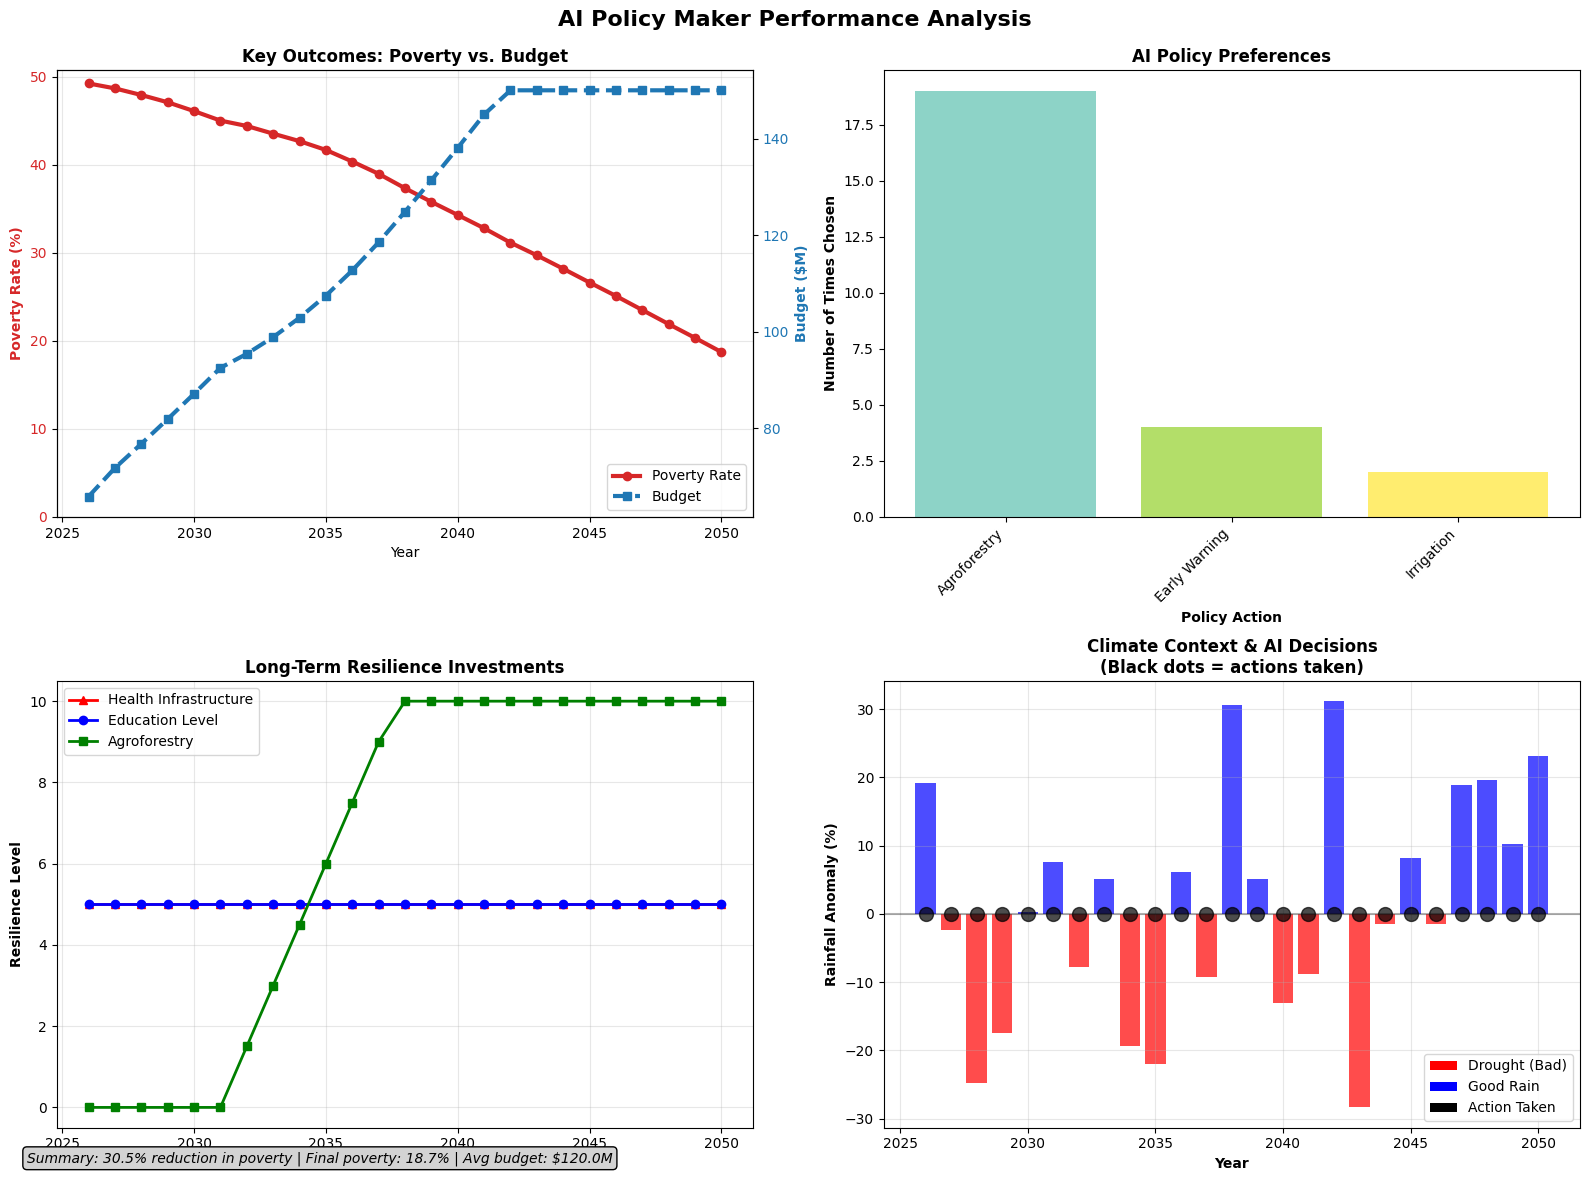


AI STRATEGY ANALYSIS
Most frequent policy: Agroforestry (76.0% of time)
Times AI chose 'Do Nothing': 0/25
❌ AI did not invest in the Dam project

AI response in 6 drought years:
  Year 2028: Early Warning
  Year 2029: Early Warning
  Year 2034: Agroforestry
  Year 2035: Agroforestry
  Year 2040: Agroforestry
  Year 2043: Agroforestry


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [22]:
# Create a figure with 4 subplots - a dashboard of results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('AI Policy Maker Performance Analysis', fontsize=16, fontweight='bold')

# Convert the history list of dictionaries to a Pandas DataFrame for easy plotting
#df = pd.DataFrame(history_data)

# --- Plot 1: Poverty and Budget Over Time (Dual Y-Axis) ---
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Poverty Rate (%)', color=color, fontweight='bold')
# Plot poverty rate
ax1.plot(df['year'], df['poverty'], color=color, linewidth=3, marker='o', label='Poverty Rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)
# Set y-axis to start from 0 for better visual impact
ax1.set_ylim(bottom=0)

# Create a second y-axis for the budget
ax1b = ax1.twinx()
color = 'tab:blue'
ax1b.set_ylabel('Budget ($M)', color=color, fontweight='bold')
# Plot budget
ax1b.plot(df['year'], df['budget'], color=color, linewidth=3, linestyle='--', marker='s', label='Budget')
ax1b.tick_params(axis='y', labelcolor=color)
# Add a legend that combines both lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1b.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
ax1.set_title('Key Outcomes: Poverty vs. Budget', fontweight='bold')

# --- Plot 2: Policy Actions Taken Over Time ---
# Map action numbers to descriptive names
action_names = {
    0: 'Do Nothing',
    1: 'Irrigation',
    2: 'Drought Crops',
    3: 'Early Warning',
    4: 'Microfinance',
    5: 'Health',
    6: 'Education',
    7: 'Agroforestry',
    8: 'Dam'
}

# Create a bar plot of actions
action_counts = df['action'].map(action_names).value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(action_counts)))
ax2.bar(action_counts.index, action_counts.values, color=colors)
ax2.set_xlabel('Policy Action', fontweight='bold')
ax2.set_ylabel('Number of Times Chosen', fontweight='bold')
ax2.set_title('AI Policy Preferences', fontweight='bold')
# Rotate x-axis labels for readability
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# --- Plot 3: Investment in Long-Term Resilience ---
# Check if these columns exist in the DataFrame before plotting
if all(col in df.columns for col in ['health_infra', 'education', 'agroforestry']):
    ax3.plot(df['year'], df['health_infra'], 'r-', linewidth=2, marker='^', label='Health Infrastructure')
    ax3.plot(df['year'], df['education'], 'b-', linewidth=2, marker='o', label='Education Level')
    ax3.plot(df['year'], df['agroforestry'], 'g-', linewidth=2, marker='s', label='Agroforestry')
    ax3.set_xlabel('Year', fontweight='bold')
    ax3.set_ylabel('Resilience Level', fontweight='bold')
    ax3.set_title('Long-Term Resilience Investments', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Long-term investment data not available\nfor this simulation run',
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Long-Term Resilience Investments', fontweight='bold')

# --- Plot 4: Climate Context & AI Response ---
# Check if rainfall data is available
if 'rain_anomaly' in df.columns:
    # Create bars for rainfall anomaly (red for drought, blue for good rain)
    colors = ['red' if x < 0 else 'blue' for x in df['rain_anomaly']]
    bars = ax4.bar(df['year'], df['rain_anomaly'] * 100, color=colors, alpha=0.7, label='Rainfall Anomaly (% vs normal)')

    # Overlay the actions taken as markers
    for i, (year, action) in enumerate(zip(df['year'], df['action'])):
        ax4.plot(year, 0, 'ko', markersize=10, alpha=0.7)  # Black dots showing action taken each year

    ax4.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax4.set_xlabel('Year', fontweight='bold')
    ax4.set_ylabel('Rainfall Anomaly (%)', fontweight='bold')
    ax4.set_title('Climate Context & AI Decisions\n(Black dots = actions taken)', fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # Add a custom legend for the climate context
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', label='Drought (Bad)'),
                       Patch(facecolor='blue', label='Good Rain'),
                       Patch(facecolor='black', label='Action Taken')]
    ax4.legend(handles=legend_elements, loc='lower right')
else:
    ax4.text(0.5, 0.5, 'Climate data not available\nfor this simulation run',
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Climate Context', fontweight='bold')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Adjust for the main title

# Add some summary statistics as text
final_poverty = df['poverty'].iloc[-1]
poverty_reduction = df['poverty'].iloc[0] - final_poverty
avg_budget = df['budget'].mean()

fig.text(0.02, 0.02, f"Summary: {poverty_reduction:.1f}% reduction in poverty | Final poverty: {final_poverty:.1f}% | Avg budget: ${avg_budget:.1f}M",
         fontstyle='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.show()

# Print a summary of AI's strategy
print("\n" + "="*60)
print("AI STRATEGY ANALYSIS")
print("="*60)
if not df.empty:
    most_common_action = df['action'].mode()[0]
    action_percentage = (df['action'].value_counts()[most_common_action] / len(df)) * 100
    print(f"Most frequent policy: {action_names[most_common_action]} ({action_percentage:.1f}% of time)")

    # Count how often AI did nothing
    do_nothing_count = len(df[df['action'] == 0])
    print(f"Times AI chose 'Do Nothing': {do_nothing_count}/{len(df)}")

    # Check if dam was ever built
    if 'dam_progress' in df.columns and df['dam_progress'].max() > 0:
        print("✅ AI successfully invested in the Dam project")
    else:
        print("❌ AI did not invest in the Dam project")

    # Analyze response to drought
    if 'rain_anomaly' in df.columns:
        drought_years = df[df['rain_anomaly'] < -0.1]  # Years with significant drought
        if not drought_years.empty:
            print(f"\nAI response in {len(drought_years)} drought years:")
            for _, row in drought_years.iterrows():
                print(f"  Year {int(row['year'])}: {action_names[row['action']]}")
else:
    print("No simulation data available for analysis")